# Advanced Business Analytics: Data Imputation Techniques
## Assignment 1 - Dataset A5

**Course:** SGH Advanced Business Analytics  
**Group:** X6  
**Date:** 2024-12-05 

**Note:** To produce more complete and visually appealing charts in the Jupyter Notebook environment, some additional libraries different from those in the original R source code are introduced. As a result, the plotting code is slightly modified, while the output remains consistent with that of the original code. 

---

### 1. Introduction & Setup
In this analysis, we aim to handle missing data in the provided dataset using Multiple Imputation by Chained Equations (MICE). We will explore the missingness mechanism, establish a baseline model using Complete Case Analysis (CCA), and optimize the number of imputations ($m$) to ensure statistical validity.

In [38]:
# Load required libraries
suppressPackageStartupMessages({
    library(tidyverse)  # Data processing & visualization
    library(VIM)        # Missing data visualization
    library(naniar)     # Missing data analysis
    library(gridExtra)  # Arrange multiple plots
    library(multcomp)
    library(mice)       # Imputation
    library(knitr)
    library(kableExtra) 
    library(IRdisplay)
})

# Set global options for cleaner output
options(width = 200, scipen = 999)

# Import data
file_path <- "https://e-web.sgh.waw.pl/akorczy/files/aba/data/task01/a5.csv"
data <- read_csv(file_path, show_col_types = FALSE)

# Check data dimension
cat("Dataset Dimension:", dim(data)[1], "rows and", dim(data)[2], "columns.\n")

Dataset Dimension: 9947 rows and 6 columns.


### 2. Data Preprocessing
We convert categorical variables into factors and assign meaningful labels to ensure readability in subsequent visualizations and models.

In [5]:
data_clean <- data %>%
  mutate(
    contact = factor(contact, levels = c(0, 1, 2), 
                     labels = c("No Communication", "Channel A", "Channel B")),
    house_loan = factor(house_loan),
    education = factor(education),
    poutcome = factor(poutcome),
    y_newdeposit = factor(y_newdeposit, levels = c(0, 1), labels = c("No", "Yes"))
  )

# Display structure
str(data_clean)

tibble [9,947 × 6] (S3: tbl_df/tbl/data.frame)
 $ age         : num [1:9947] 33 41 58 45 60 56 40 36 60 37 ...
 $ education   : Factor w/ 4 levels "primary","secondary",..: 4 2 4 4 1 3 1 2 2 2 ...
 $ house_loan  : Factor w/ 2 levels "no","yes": 1 2 2 2 2 2 2 2 2 2 ...
 $ contact     : Factor w/ 3 levels "No Communication",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ poutcome    : Factor w/ 4 levels "failure","other",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ y_newdeposit: Factor w/ 2 levels "No","Yes": 1 NA 1 1 1 1 1 NA 1 1 ...


### 3. Exploratory Data Analysis (EDA)
Before handling missing values, we examine the distribution of variables.

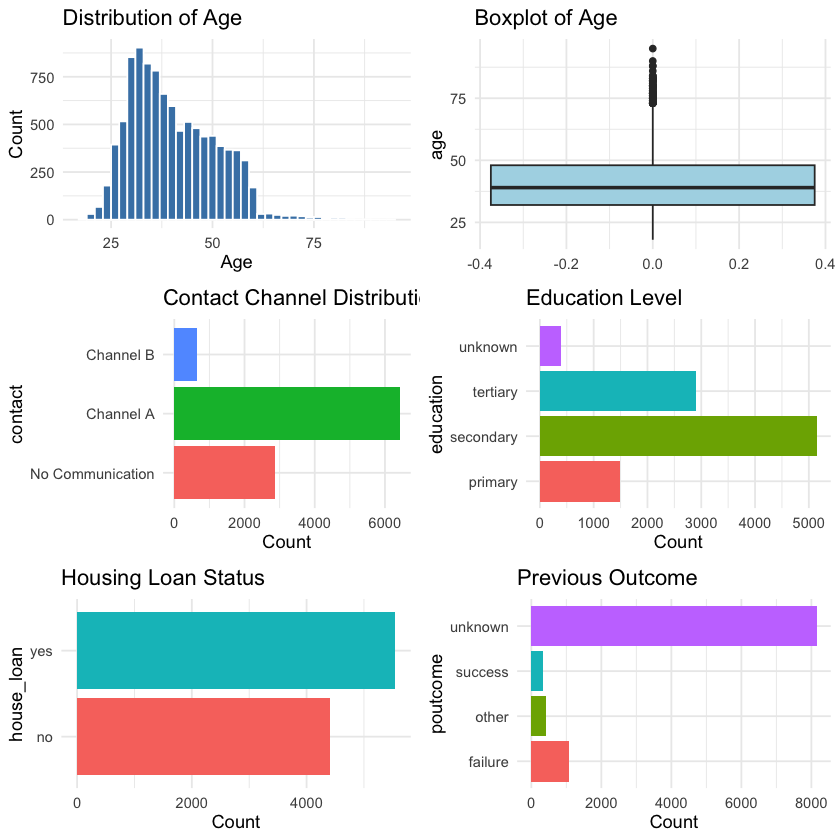

In [6]:
# --- Continuous variable: Age ---
p1 <- ggplot(data_clean, aes(x = age)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
  theme_minimal() +
  labs(title = "Distribution of Age", x = "Age", y = "Count")

p2 <- ggplot(data_clean, aes(y = age)) +
  geom_boxplot(fill = "lightblue") +
  theme_minimal() +
  labs(title = "Boxplot of Age")

# --- Categorical variables ---
plot_bar <- function(df, col_name, title) {
  ggplot(df, aes(x = .data[[col_name]], fill = .data[[col_name]])) +
    geom_bar() +
    theme_minimal() +
    theme(legend.position = "none") +
    labs(title = title, x = col_name, y = "Count") +
    coord_flip()
}

p3 <- plot_bar(data_clean, "contact", "Contact Channel Distribution")
p4 <- plot_bar(data_clean, "education", "Education Level")
p5 <- plot_bar(data_clean, "house_loan", "Housing Loan Status")
p6 <- plot_bar(data_clean, "poutcome", "Previous Outcome")

# Arrange plots
grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 2)

### 4. Missing Data Analysis
We analyze the proportion and patterns of missing data to determine if the data is Missing Completely at Random (MCAR), Missing at Random (MAR), or Missing Not at Random (MNAR).

HTML widgets cannot be represented in plain text (need html)


 Variables sorted by number of missings: 
     Variable     Count
 y_newdeposit 0.1619584
          age 0.0000000
    education 0.0000000
   house_loan 0.0000000
      contact 0.0000000
     poutcome 0.0000000


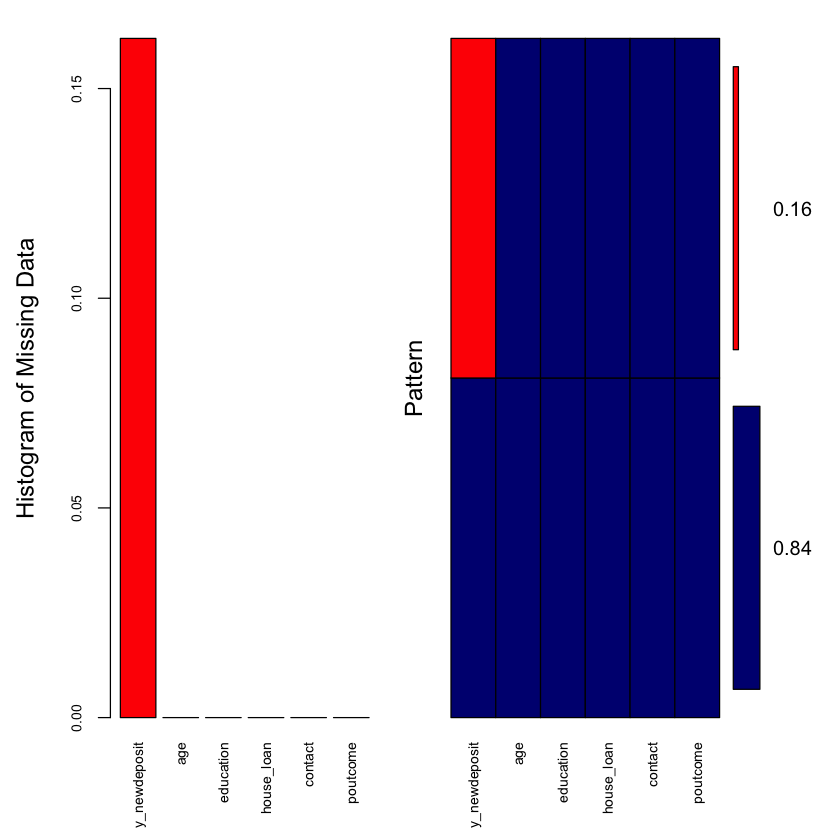

In [7]:
# Missing data proportions
missing_summary <- data_clean %>%
  summarise_all(~sum(is.na(.))) %>%
  gather(key = "Variable", value = "Missing_Count") %>%
  mutate(Percent = Missing_Count / nrow(data_clean) * 100) %>%
  arrange(desc(Percent))

# Render interactive table
datatable(missing_summary, options = list(pageLength = 5, dom = 't'))

# Visualize missingness pattern
aggr_plot <- aggr(data_clean, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
                  labels=names(data_clean), cex.axis=.7, gap=3, 
                  ylab=c("Histogram of Missing Data","Pattern"))

#### 4.1 Statistical Tests for Missingness
We compare the distribution of observed variables between groups where `y_newdeposit` is missing versus observed. Significant differences suggest the data is NOT MCAR.


	Welch Two Sample t-test

data:  age by is_missing_y
t = 35.485, df = 2038.6, p-value < 0.00000000000000022
alternative hypothesis: true difference in means between group Missing and group Observed is not equal to 0
95 percent confidence interval:
 10.24583 11.44457
sample estimates:
 mean in group Missing mean in group Observed 
              49.88454               39.03935 


--- Chi-square test for: contact ---

	Pearson's Chi-squared test

data:  tab
X-squared = 178.22, df = 2, p-value < 0.00000000000000022


--- Chi-square test for: house_loan ---

	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 53.83, df = 1, p-value = 0.0000000000002186


--- Chi-square test for: education ---

	Pearson's Chi-squared test

data:  tab
X-squared = 91.793, df = 3, p-value < 0.00000000000000022


--- Chi-square test for: poutcome ---

	Pearson's Chi-squared test

data:  tab
X-squared = 16.065, df = 3, p-value = 0.0011



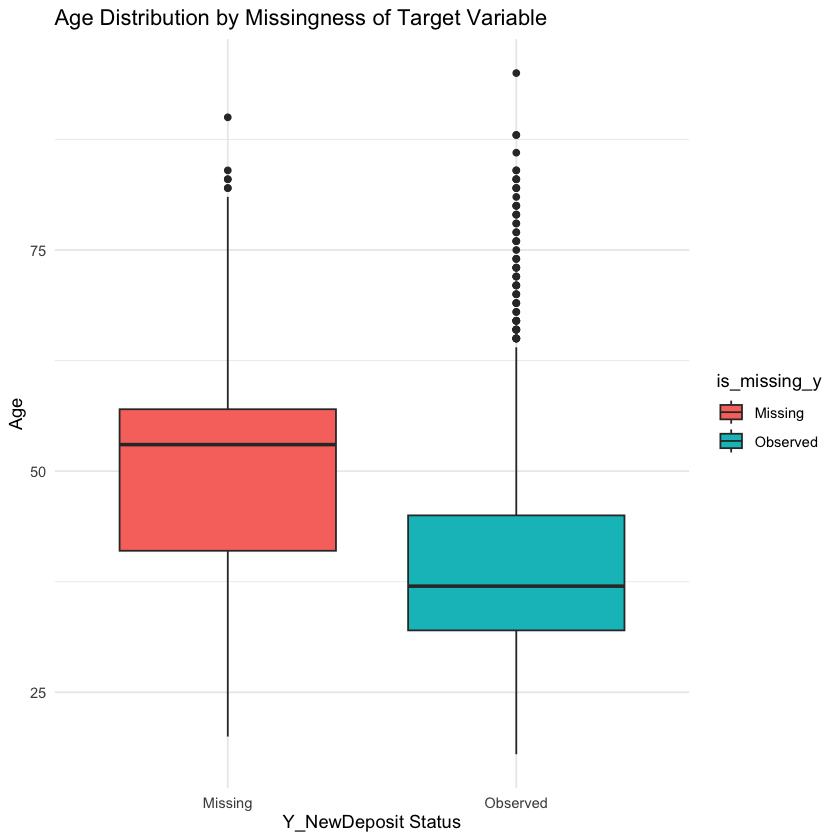

In [8]:
data_check <- data_clean %>%
  mutate(is_missing_y = ifelse(is.na(y_newdeposit), "Missing", "Observed"))

# Visual inspection: Age
p_miss_age <- ggplot(data_check, aes(x = is_missing_y, y = age, fill = is_missing_y)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Age Distribution by Missingness of Target Variable",
       x = "Y_NewDeposit Status", y = "Age")
print(p_miss_age)

# T-test for Age
print(t.test(age ~ is_missing_y, data = data_check))

# Chi-square tests for categorical variables
categorical_vars <- c("contact", "house_loan", "education", "poutcome")
for (var in categorical_vars) {
  tab <- table(data_check$is_missing_y, data_check[[var]])
  test <- chisq.test(tab)
  cat(sprintf("\n--- Chi-square test for: %s ---\n", var))
  print(test)
}

#### 4.2 Logistic Regression for Missingness
We build a logistic regression model to predict missingness. If predictors are significant, it supports the MAR assumption.

In [9]:
data_check$is_missing_numeric <- ifelse(data_check$is_missing_y == "Missing", 1, 0)

missing_model <- glm(is_missing_numeric ~ age + contact + education + house_loan + poutcome, 
                     data = data_check, 
                     family = binomial(link = "logit"))

summary(missing_model)

# Odds Ratios
cat("\n--- Odds Ratios ---\n")
print(exp(coef(missing_model)))


Call:
glm(formula = is_missing_numeric ~ age + contact + education + 
    house_loan + poutcome, family = binomial(link = "logit"), 
    data = data_check)

Coefficients:
                    Estimate Std. Error z value             Pr(>|z|)    
(Intercept)        -5.621263   0.217940 -25.793 < 0.0000000000000002 ***
age                 0.099346   0.003182  31.221 < 0.0000000000000002 ***
contactChannel A   -0.576512   0.070523  -8.175 0.000000000000000296 ***
contactChannel B   -0.002247   0.113734  -0.020               0.9842    
educationsecondary  0.033044   0.081211   0.407               0.6841    
educationtertiary   0.005670   0.092189   0.062               0.9510    
educationunknown   -0.149386   0.152067  -0.982               0.3259    
house_loanyes      -0.048506   0.064311  -0.754               0.4507    
poutcomeother      -0.443663   0.204733  -2.167               0.0302 *  
poutcomesuccess    -0.460500   0.211814  -2.174               0.0297 *  
poutcomeunknown    -0.033


--- Odds Ratios ---
       (Intercept)                age   contactChannel A   contactChannel B educationsecondary  educationtertiary   educationunknown      house_loanyes      poutcomeother    poutcomesuccess 
       0.003620066        1.104447838        0.561854818        0.997755037        1.033596114        1.005686151        0.861236828        0.952651926        0.641681892        0.630967941 
   poutcomeunknown 
       0.967165624 


### 5. Model Building
#### 5.1 MCAR Assumption: Complete Case Analysis (CCA)

In [10]:
model_formula <- y_newdeposit ~ age + contact + house_loan + poutcome + education

data_no_missing <- data_clean %>% drop_na()

model_cca <- glm(model_formula,
                 data = data_no_missing,
                 family = binomial(link = "logit"))

summary(model_cca)


Call:
glm(formula = model_formula, family = binomial(link = "logit"), 
    data = data_no_missing)

Coefficients:
                    Estimate Std. Error z value             Pr(>|z|)    
(Intercept)        -2.272352   0.269877  -8.420 < 0.0000000000000002 ***
age                -0.008825   0.004083  -2.162              0.03065 *  
contactChannel A    0.930243   0.119617   7.777  0.00000000000000744 ***
contactChannel B    1.033828   0.182317   5.670  0.00000001423825554 ***
house_loanyes      -0.650713   0.076526  -8.503 < 0.0000000000000002 ***
poutcomeother       0.069776   0.176917   0.394              0.69329    
poutcomesuccess     2.208930   0.160980  13.722 < 0.0000000000000002 ***
poutcomeunknown    -0.368564   0.110044  -3.349              0.00081 ***
educationsecondary  0.232742   0.130399   1.785              0.07429 .  
educationtertiary   0.424294   0.135193   3.138              0.00170 ** 
educationunknown    0.118018   0.232193   0.508              0.61126    
---
Signi

#### 5.2 MAR Assumption: Multiple Imputation (MICE)
We need to determine the optimal number of imputations ($m$). We will iterate through $m \in \{20, 40, ..., 140\}$ and monitor the stability of coefficients, RIV (Relative Increase in Variance), and FMI (Fraction of Missing Information).

In [39]:
# Function to diagnose the imputation model

run_MI_logit <- function(m_value) {
  imp <- mice(data_clean, m = m_value, method = "logreg",
              seed = 123, print = FALSE)
   
  fit <- with(imp, 
              glm(y_newdeposit ~ age +
                    relevel(contact, ref = "Channel B") +
                    house_loan + education + poutcome,
                  family = binomial))
   
  pooled <- pool(fit)
  out <- pooled$pooled
   
  # Extract key stability metrics
  return(list(
    m = m_value,
    pooled = out,
    riv = out$riv,
    fmi = out$fmi,
    coef = out$estimate
  ))
}

# ---------------------------------------------------------
# Diagnose initial model
# ---------------------------------------------------------
diag_result <- run_MI_logit(m=5)

display_html("<h3>Initial Model Diagnosis (m=5)</h3>") 

html_table1 <- diag_result$pooled %>%
  kable(format = "html", digits = 3, caption = "Pooled Results for m=5") %>%
  kable_styling(full_width = TRUE, bootstrap_options = c("striped", "hover", "condensed")) %>%
  scroll_box(width = "100%", height = "400px")

display_html(as.character(html_table1)) 

# ---------------------------------------------------------
# Values of m to test 
# ---------------------------------------------------------
m_values <- c(20, 40, 60, 80, 100, 120, 140)
results <- lapply(m_values, run_MI_logit)

coef_table <- do.call(rbind, lapply(results, function(x) {
  data.frame(
    m = x$m,
    variable = x$pooled$term,
    estimate = x$coef,
    riv = x$riv,
    fmi = x$fmi
  )
}))

# ---------------------------------------------------------
# Combine pooled coefficients into a dataframe for comparison
# ---------------------------------------------------------
display_html("<h3>Comparison of different m values</h3>")

html_table2 <- coef_table %>%
  kable(format = "html", digits = 4) %>%
  kable_styling(full_width = TRUE, bootstrap_options = c("striped", "hover")) %>%
  scroll_box(width = "100%", height = "600px")

display_html(as.character(html_table2)) 

Initial Model Diagnosis (m=5)

term,m,estimate,ubar,b,t,dfcom,df,riv,lambda,fmi
(Intercept),5,-1.237,0.061,0.045,0.114,9936,18.047,0.887,0.470,0.520
age,5,-0.009,0.000,0.000,0.000,9936,80.407,0.285,0.222,0.241
"relevel(contact, ref = ""Channel B"")No Communication",5,-1.069,0.024,0.026,0.055,9936,12.823,1.261,0.558,0.614
"relevel(contact, ref = ""Channel B"")Channel A",5,-0.114,0.016,0.029,0.051,9936,8.391,2.220,0.689,0.744
house_loanyes,5,-0.643,0.005,0.001,0.006,9936,232.857,0.148,0.129,0.137
educationsecondary,5,0.256,0.013,0.001,0.014,9936,963.804,0.065,0.061,0.063
educationtertiary,5,0.451,0.014,0.002,0.017,9936,152.868,0.191,0.160,0.171
educationunknown,5,0.150,0.042,0.009,0.053,9936,89.111,0.267,0.211,0.228
poutcomeother,5,0.037,0.028,0.001,0.030,9936,1031.835,0.062,0.059,0.061
poutcomesuccess,5,2.177,0.022,0.003,0.026,9936,188.975,0.168,0.144,0.153


Comparison of different m values

m,variable,estimate,riv,fmi
20,(Intercept),-1.2560,0.7632,0.4439
20,age,-0.0085,0.8426,0.4691
20,"relevel(contact, ref = ""Channel B"")No Communication",-1.0042,0.4171,0.3009
20,"relevel(contact, ref = ""Channel B"")Channel A",-0.0865,0.7163,0.4279
20,house_loanyes,-0.6539,0.0830,0.0774
20,educationsecondary,0.2227,0.2181,0.1820
20,educationtertiary,0.4226,0.2947,0.2320
20,educationunknown,0.0635,0.2170,0.1813
20,poutcomeother,0.0559,0.0726,0.0683
20,poutcomesuccess,2.2293,0.1108,0.1009


### 6. Diagnostic Visualization
We visualize the stability of parameters to justify our choice of $m$.

### 6.1 Stability of Coefficients
First, we examine the stability of the regression coefficients across different numbers of imputations ($m$). We look for the point where the estimates settle down and stop fluctuating significantly.

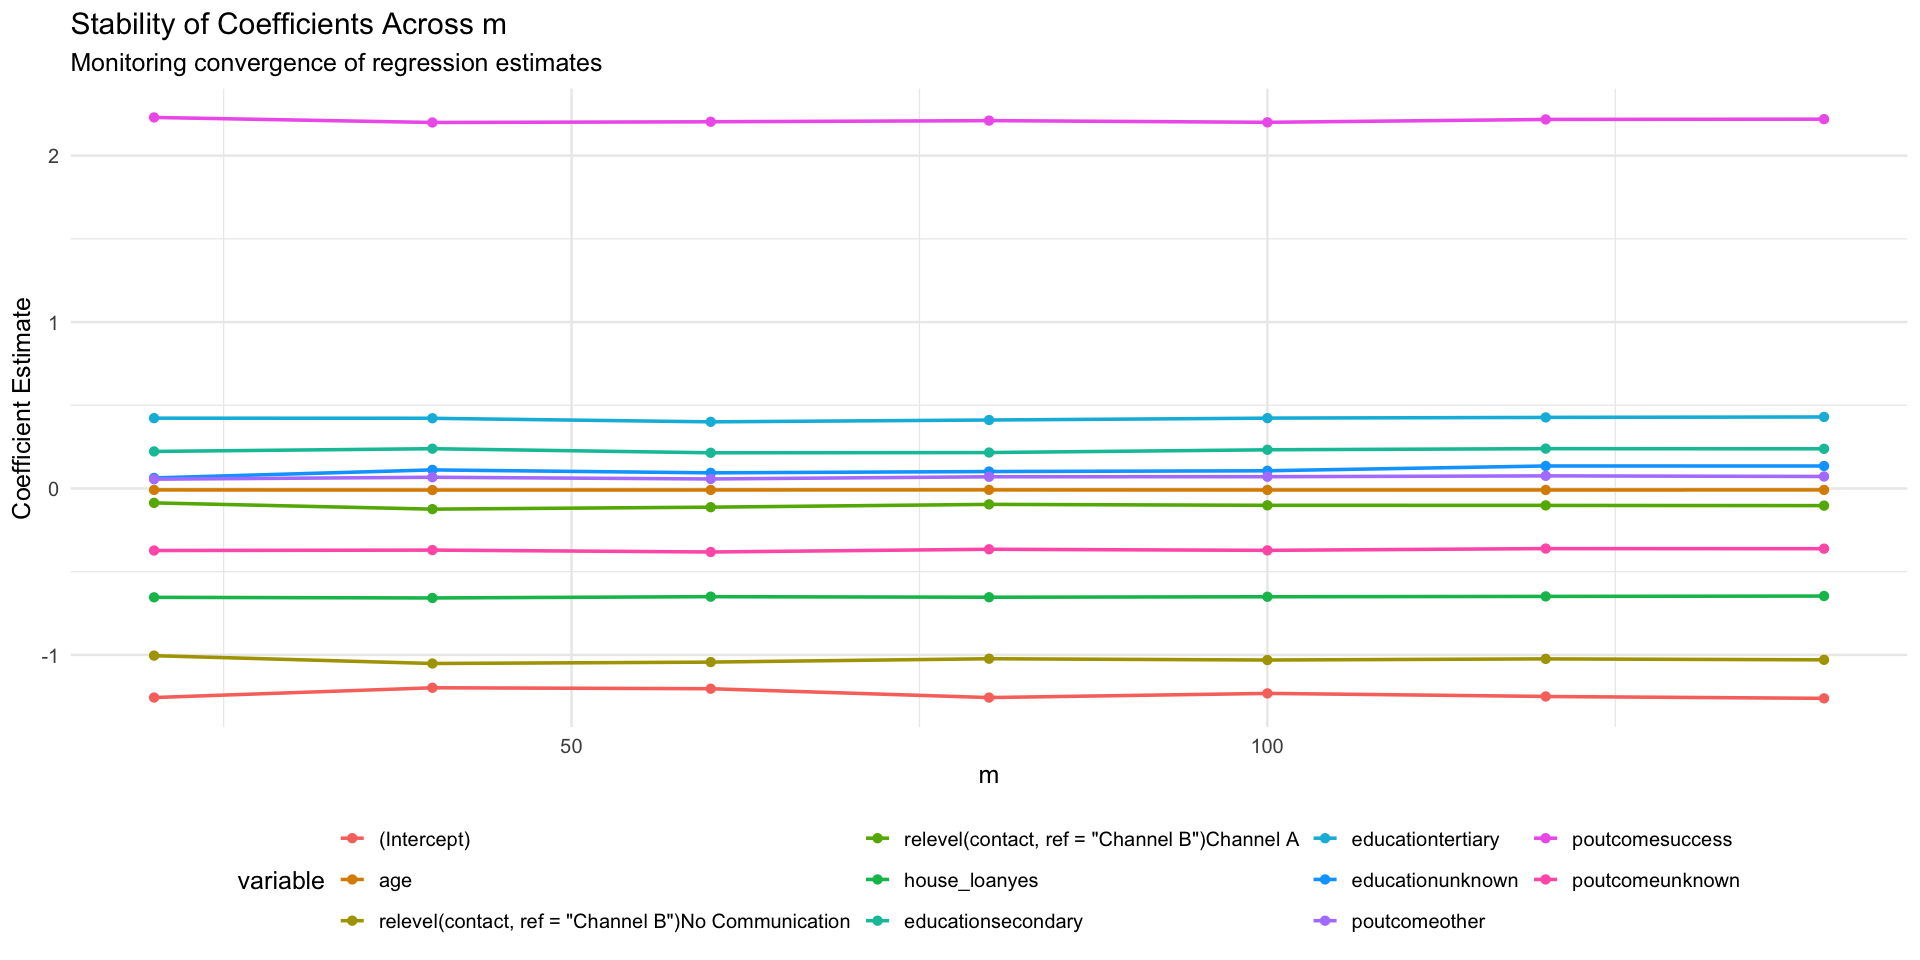

In [27]:
# 1. Coefficient Stability Plot
options(repr.plot.width = 16, repr.plot.height = 8)
p_est <- ggplot(coef_table, aes(x = m, y = estimate, color = variable)) +
  geom_line(linewidth = 1) + 
  geom_point(size = 2) +
  theme_minimal(base_size = 15) +
  labs(title = "Stability of Coefficients Across m", 
       subtitle = "Monitoring convergence of regression estimates",
       y = "Coefficient Estimate") +
  theme(legend.position = "bottom",
        legend.box.spacing = unit(0.5, "cm")) 

print(p_est)

### 6.2 Relative Increase in Variance (RIV)
RIV measures the increase in variance of the regression coefficients due to missing data. Stable RIV values indicate that adding more imputations does not significantly change our uncertainty estimates.

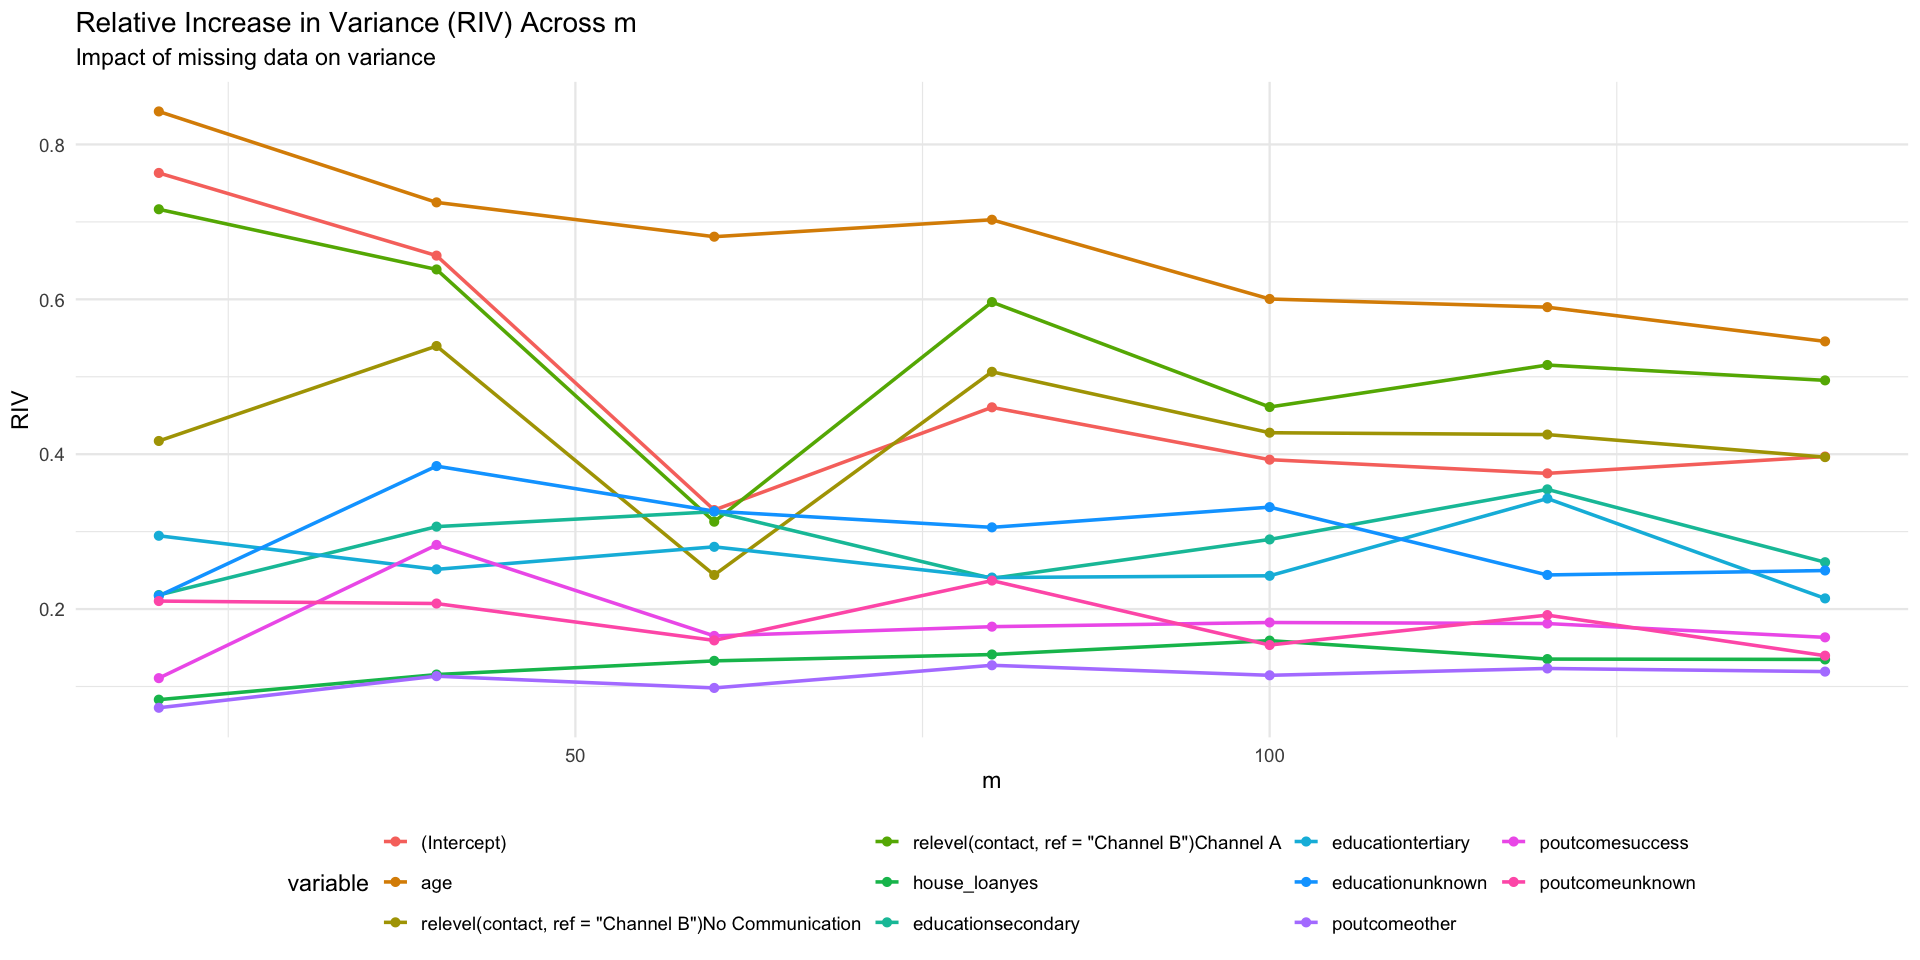

In [28]:
# 2. RIV Stability Plot

p_riv <- ggplot(coef_table, aes(x = m, y = riv, color = variable)) +
  geom_line(linewidth = 1) + 
  geom_point(size = 2) +
  theme_minimal(base_size = 14) +
  labs(title = "Relative Increase in Variance (RIV) Across m", 
       subtitle = "Impact of missing data on variance",
       y = "RIV") +
  theme(legend.position = "bottom") 

print(p_riv)

### 6.3 Fraction of Missing Information (FMI)
FMI represents the proportion of total variance attributable to the missing data. Like RIV, we expect this metric to stabilize as $m$ increases.

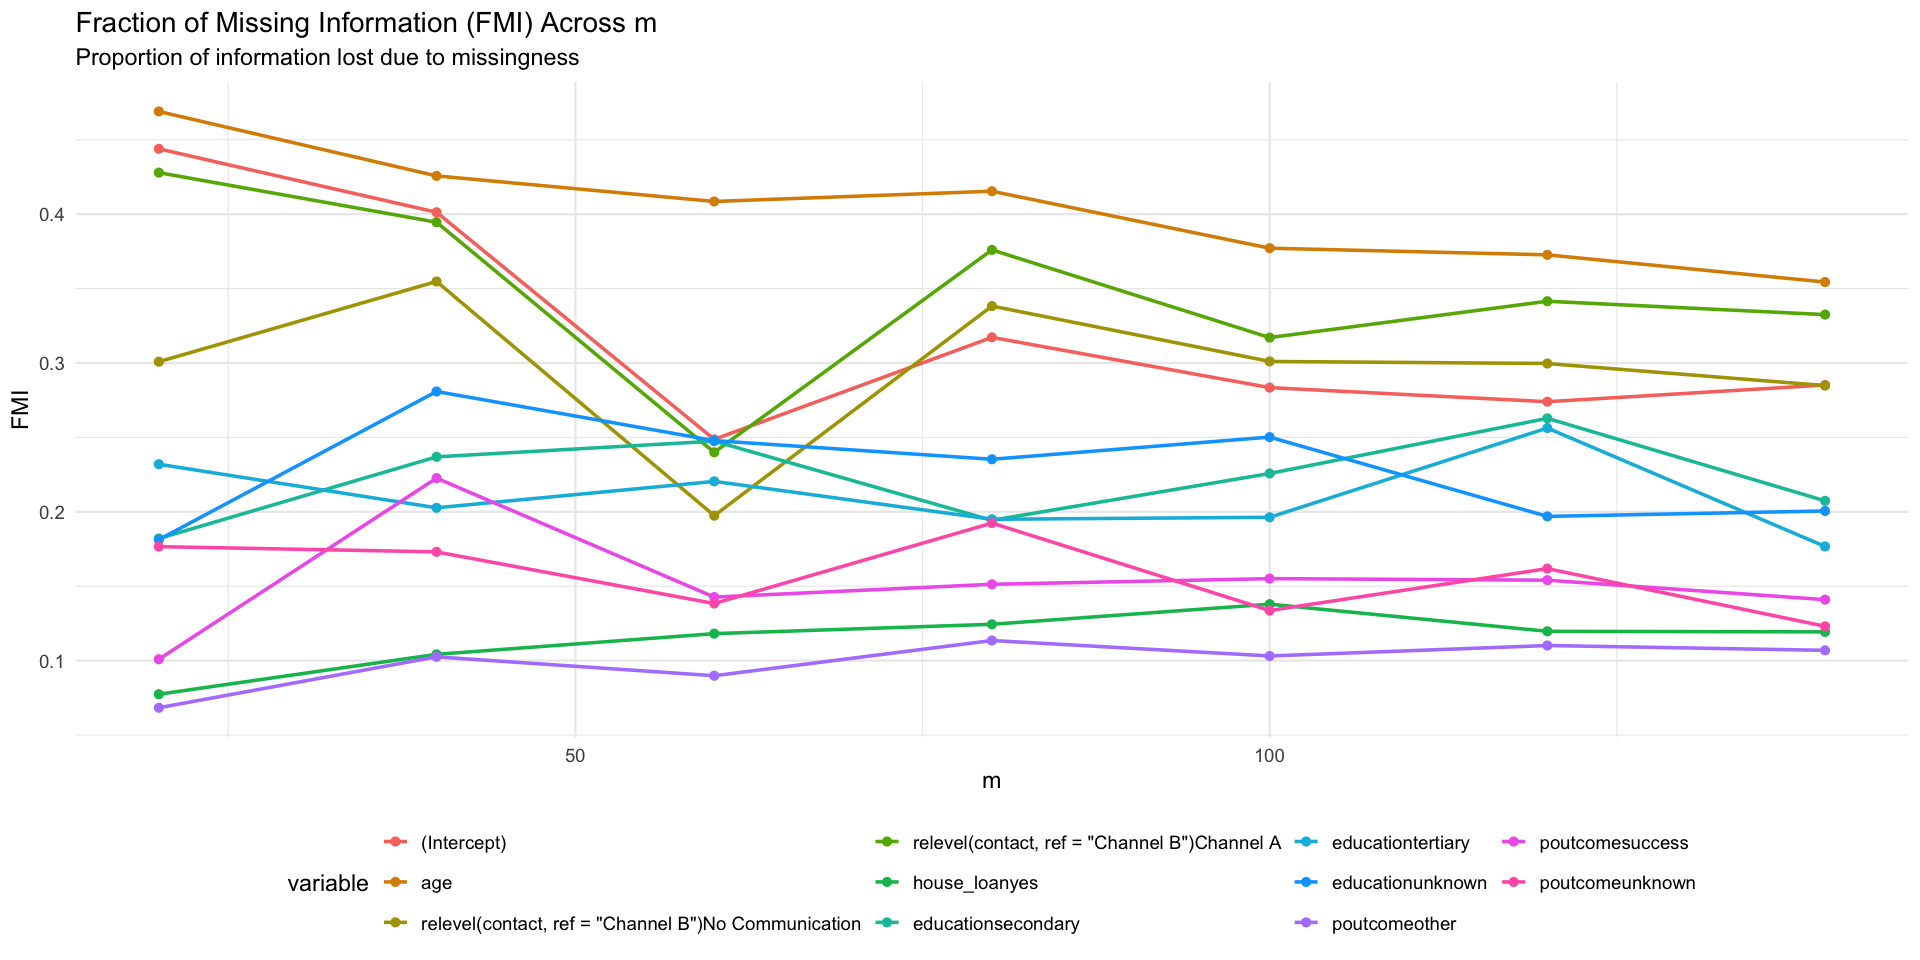

In [29]:
# 3. FMI Stability Plot
p_fmi <- ggplot(coef_table, aes(x = m, y = fmi, color = variable)) +
  geom_line(linewidth = 1) + 
  geom_point(size = 2) +
  theme_minimal(base_size = 14) +
  labs(title = "Fraction of Missing Information (FMI) Across m", 
       subtitle = "Proportion of information lost due to missingness",
       y = "FMI") +
  theme(legend.position = "bottom")

print(p_fmi)

### 7. Final Model Estimation
Based on the diagnostics, we select **$m = 100$** to ensure convergence and stability of the estimates.

In [13]:
# Final Imputation with m = 100
imp_data_final <- mice(data_clean, m = 100, method = 'logreg', seed = 123, print = FALSE)

# Fit model
fit_imp_final <- with(imp_data_final, glm(y_newdeposit ~ age + 
                                relevel(contact, ref = "Channel B") +
                                house_loan + education + poutcome, 
                              family = binomial(link = "logit")))

# Pool results
pooled_results_final <- pool(fit_imp_final)

# Display final summary
summary(pooled_results_final, conf.int = TRUE)

,term,estimate,std.error,statistic,df,p.value,2.5 %,97.5 %,conf.low,conf.high
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),-1.230989181,0.290645525,-4.2353626,1059.2702,0.000024801299768344951666336831164194620669150,-1.80129558,-0.6606827787,-1.80129558,-0.6606827787
2,age,-0.008970865,0.004111743,-2.1817669,631.7412,0.029494543493709217407694467283363337628543377,-0.01704520,-0.0008965275,-0.01704520,-0.0008965275
3,"relevel(contact, ref = ""Channel B"")No Communication",-1.030618602,0.186269148,-5.5329539,951.9685,0.000000040698809950217370639822850493516614989,-1.39616418,-0.6650730249,-1.39616418,-0.6650730249
4,"relevel(contact, ref = ""Channel B"")Channel A",-0.101143777,0.152429764,-0.6635435,867.6343,0.507158799493778955636003047402482479810714722,-0.40031797,0.1980304125,-0.40031797,0.1980304125
5,house_loanyes,-0.650461974,0.077220354,-8.4234524,3253.4400,0.000000000000000054101650091188578721695057206,-0.80186741,-0.4990565350,-0.80186741,-0.4990565350
6,educationsecondary,0.232669265,0.130287209,1.7858182,1562.2711,0.074322610646129841360796319804649101570248604,-0.02288696,0.4882254914,-0.02288696,0.4882254914
7,educationtertiary,0.422864112,0.133439349,3.1689612,1956.5091,0.001553486876435962839651527822582011140184477,0.16116590,0.6845623238,0.16116590,0.6845623238
8,educationunknown,0.106607940,0.237400156,0.4490643,1314.7344,0.653459266985500830671185212850105017423629761,-0.35911656,0.5723324427,-0.35911656,0.5723324427
9,poutcomeother,0.070780450,0.176328735,0.4014119,4571.7834,0.688135662450920282395827598520554602146148682,-0.27490904,0.4164699389,-0.27490904,0.4164699389
